## This is a notebook that integrates the training of two architectrures of NN over the histoloung (INSERT OTHER NAME) 600 dataset.
## It has two differentiated cells for each network architecture. 
## On top, it will implement a search of the best architecture with tunersearch. 

In [1]:
# import tensorflow as tf
# import numpy as np
# import matplotlib.pyplot as plt

# from keras import layers
# from keras import models
# from keras.models import Model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import EfficientNetB4
# from sklearn.model_selection import train_test_split

# from PIL import Image


# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# from tensorflow.keras.utils import Sequence
# import os
# from datetime import datetime

# from tensorflow.keras.layers.experimental import preprocessing
# import mlflow

# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers.experimental import preprocessing
import mlflow

from keras import layers
from keras import models
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score


In [3]:
# Choose the Type of architecture to train

Architecture = 'EfficientNetB4'
# Architecture = 'CNN'

In [4]:
# Define the root directory where your data is stored
root_directory = "dataset_2_final"

# Get the list of subdirectories (categories)
subdirectories = [subdir for subdir in os.listdir(root_directory) if os.path.isdir(os.path.join(root_directory, subdir))]

# Create lists to store image paths and corresponding labels
image_paths = []
labels = []

# Iterate through each subdirectory (category)
for label, subdirectory in enumerate(subdirectories):
    # Construct the full path to the subdirectory
    subdirectory_path = os.path.join(root_directory, subdirectory)

    # Get a list of image files in the subdirectory
    image_files = [os.path.join(subdirectory_path, filename) for filename in os.listdir(subdirectory_path) if filename.endswith('.jpg')]  # Adjust the file extension as needed
    
    # Append image paths and labels
    image_paths.extend(image_files)
    labels.extend([label] * len(image_files))


# Print the number of images and labels
print("Total images:", len(image_paths))
print("Total labels:", len(labels))

Total images: 494
Total labels: 494


In [5]:
# Define the load_image function as a standalone function. It gets used in the data generator and in the inference section

def load_image(image_path, image_size):
    # Load the original image using Pillow
    original_image = Image.open(image_path)
    original_image_array = np.array(original_image)

    # Split the original image into 4 pieces
    h, w, c = original_image_array.shape
    h_half, w_half = h // 2, w // 2

    image_pieces = [
        original_image_array[:h_half, :w_half],
        original_image_array[:h_half, w_half:],
        original_image_array[h_half:, :w_half],
        original_image_array[h_half:, w_half:]
    ]

    # Resize the image pieces and provide the shape of the output
    resized_images = [tf.image.resize(piece, image_size) for piece in image_pieces]

    return resized_images

Here we create a custom data generator that inherits from the Sequence class /

Main function is to load images in batches and split them in four pieces such that each data is augmented 4 times/

TODO add some randomnes at the time of loading the images. Don't know if it neccessary really.... Ask Pere 



In [6]:

class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, image_size):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_samples = 4 * len(image_paths)
        self.indices = np.arange(self.num_samples)

    def __len__(self):        

        # I calculate the number of batches
        return int(np.ceil(self.num_samples / self.batch_size))
    
    
    # def load_image(self, image_path):
    #     #Load the original image using Pillow
    #     original_image = Image.open(image_path)
    #     original_image_array = np.array(original_image)

    #     # Split the original image into 4 pieces
    #     h, w, c = original_image_array.shape
    #     h_half, w_half = h // 2, w // 2
       
    #     image_pieces = [
    #         original_image_array[:h_half, :w_half],
    #         original_image_array[:h_half, w_half:],
    #         original_image_array[h_half:, :w_half],
    #         original_image_array[h_half:, w_half:]
    #     ]
        
    #     # Resize the image pieces and provide the shape of the output
    #     resized_images = [tf.image.resize(piece, self.image_size) for piece in image_pieces]

    #     #Shape of resized image list
    #     #print(np.array(resized_images).shape)
    #     return resized_images        


    def __getitem__(self, index):

        #This function is called when you call the generator. It generates a batch of indices by slicing
        batch_indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]

        batch_images = []
        batch_labels = []

        # Iterate over indices in the current batch
        for batch_index in batch_indices:

            # Calculate the index of the original image and the piece index within it
            image_index = batch_index // 4   # Divide by 4 to get original image index
            piece_index = batch_index % 4    # Modulus 4 to get piece index

            # Get the image path and original label for the current image
            image_path = self.image_paths[image_index]
            original_label = self.labels[image_index]
            # Call the load_image function here
            image_pieces = load_image(image_path, self.image_size)

            # Load and split the image into pieces
            piece = image_pieces[piece_index]
            batch_images.append(piece)
            batch_labels.append(original_label)


        batch_images = np.array(batch_images)
        batch_labels = np.array(batch_labels)

        return batch_images, batch_labels


        
        


Some settings relative to the different architectures of NN trained. If we are going to compare performances of both networks, they should be same, right? Ask Pere

For reference: 

- Private images are 1600x1200 (800 x 600 when splitted)
- Public images are 768 x 768

Also: 

- Effientnet 4 accepts 380 x 380
- Custom CNN accepts 255 as much (resource error otherwise) 

In [24]:
batch_size = 16

if Architecture == 'EfficientNetB4':
    image_size = (380, 380)  # Adjust the image size based on your model's input requirements

elif Architecture == 'CNN':
    #This image size is close to the largest I can use with this architecture. 
    image_size = (255, 255)


#Make training and validation sets. The test set, I will handle independently in another file
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)


# Create data generators for training, validation, and test sets
train_generator = CustomDataGenerator(train_paths, train_labels, batch_size, image_size)
val_generator = CustomDataGenerator(val_paths, val_labels, batch_size, image_size)



In [25]:

# Calculate the sizes of the datasets
train_size = len(train_paths)
val_size = len(val_paths)
# test_size = len(test_paths)

# Print the sizes
print(f"Training Set Size: {train_size} samples")
print(f"Validation Set Size: {val_size} samples")
# print(f"Test Set Size: {test_size} samples")


Training Set Size: 395 samples
Validation Set Size: 99 samples


In [26]:
if Architecture == 'EfficientNetB4':

    base_model = EfficientNetB4(include_top = False ,weights='imagenet', pooling='avg')

    # Introduce a layer of data augmentation
    data_augmentation = Sequential([
        preprocessing.RandomRotation(0.2),
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomZoom(0.2),
        preprocessing.RandomContrast(0.2),
        preprocessing.RandomTranslation(0.2, 0.2),
        preprocessing.RandomHeight(0.2),
        preprocessing.RandomWidth(0.2),
    ])

    # Freeze all layers in the base model
    for layer in base_model.layers:
        layer.trainable = False
    # Unfreeze the last 10 layers in the base model for fine-tuning
    for layer in base_model.layers[-5:]:
        layer.trainable = True

    
    #capa de entradas. 
    entradas = layers.Input((380, 380, 3))

    # Capa de augmentation
    x = data_augmentation(entradas)
    # Pass the augmented images through the base model
    x = base_model(x)
    # Add a dense layer
    x = layers.Dense(256, activation='relu')(x)
    # Add another dense layer
    salidas = layers.Dense(7, activation='softmax')(x)


    model = Model(inputs = entradas, outputs = salidas)
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    model.summary()

    
elif Architecture == 'CNN':

    input_shape = (255, 255, 3)

    
    model=models.Sequential()

    model.add(layers.Rescaling(scale = 1./255, offset=0.0, input_shape=input_shape))
    model.add(layers.Input(input_shape))

    model.add(layers.RandomFlip("horizontal_and_vertical"))
    model.add(layers.RandomRotation(0.2))
    model.add(layers.RandomZoom(0.2))
    model.add(layers.RandomContrast(0.2))
    model.add(layers.RandomTranslation(0.2, 0.2))
    # model.add(layers.RandomHeight(0.2))
    # model.add(layers.RandomWidth(0.2))


    model.add(layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu',))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=64, kernel_size=(2,2), activation='relu',))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=128, kernel_size=(2,2), activation='relu',))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=256, kernel_size=(2,2), activation='relu',))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=512, kernel_size=(2,2), activation='relu',))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Add flatten layer
    model.add(layers.Flatten())

    # Add dense/dropout layers + activation functions

    model.add(layers.Dense(512, activation = 'relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(256, activation = 'relu'))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(7, activation = 'softmax'))

    adamop = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    model.compile(optimizer = adamop, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 380, 380, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
dense (Dense)                (None, 256)               459008    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1799      
Total params: 18,134,630
Trainable params: 1,267,207
Non-trainable params: 16,867,423
_________________________________________________________________


In [27]:
tf.keras.backend.clear_session()

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, mode='auto', verbose = 1)

In [29]:
mlflow.end_run()

In [30]:
# Start an MLflow run
mlflow.start_run()
mlflow.set_experiment('scientific_data')
# Log the name of the dataset
epochs = 5
# Train the model using the custom data generators and the debugging callback
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator, shuffle=True, callbacks=[early_stopping])

Epoch 1/5
99/99 [==============================] - 411s 4s/step - loss: 1.6763 - accuracy: 0.3614 - val_loss: 1.4682 - val_accuracy: 0.4470
Epoch 2/5
99/99 [==============================] - 370s 4s/step - loss: 1.4171 - accuracy: 0.4778 - val_loss: 1.3416 - val_accuracy: 0.5429
Epoch 3/5
99/99 [==============================] - 422s 4s/step - loss: 1.2802 - accuracy: 0.5272 - val_loss: 1.2748 - val_accuracy: 0.5455
Epoch 4/5
99/99 [==============================] - 463s 5s/step - loss: 1.1461 - accuracy: 0.5677 - val_loss: 1.4908 - val_accuracy: 0.6010
Epoch 5/5
99/99 [==============================] - 434s 4s/step - loss: 1.0958 - accuracy: 0.5911 - val_loss: 1.3879 - val_accuracy: 0.5505


In [34]:

#Logging
mlflow.log_param("epochs", epochs)
mlflow.log_param("batch_size", batch_size)
#mlflow.log_param("parameters", num_params)
#mlflow.log_metric("val_loss", loss)
#mlflow.log_metric("val_accuracy", accuracy)
mlflow.end_run()


In [35]:
history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [36]:
folder_date = 'old_models/' +  datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
os.mkdir(folder_date)
filepath_model = folder_date + '/my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'

In [37]:
#Guardo el modelo en la última epoch
model.save(folder_date + '/modelo_entrenado.h5')

c:\Users\diosdadj\Anaconda3\envs\ml\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


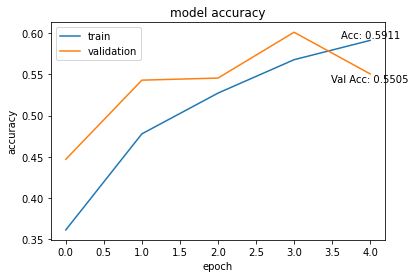

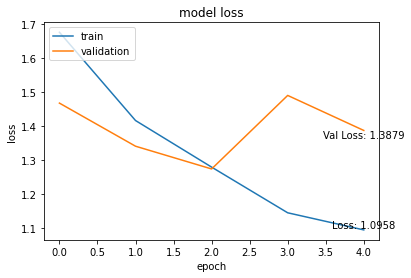

In [38]:
print(history.history.keys())

#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.text(len(history.history['accuracy'])-1, history.history['accuracy'][-1], 
         f"Acc: {history.history['accuracy'][-1]:.4f}", ha='center', va='bottom')
plt.text(len(history.history['val_accuracy'])-1, history.history['val_accuracy'][-1], 
         f"Val Acc: {history.history['val_accuracy'][-1]:.4f}", ha='center', va='top')


plt.savefig(folder_date + "/accuracy.png")
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.text(len(history.history['loss'])-1, history.history['loss'][-1], 
         f"Loss: {history.history['loss'][-1]:.4f}", ha='center', va='bottom')
plt.text(len(history.history['val_loss'])-1, history.history['val_loss'][-1], 
         f"Val Loss: {history.history['val_loss'][-1]:.4f}", ha='center', va='top')


plt.savefig(folder_date + "/loss.png")
plt.show()


For dubug purposes only. I load a model that is trained already

In [39]:
# model = tf.keras.models.load_model('old_models/2023_09_24-04_59_50_PM/modelo_entrenado.h5')

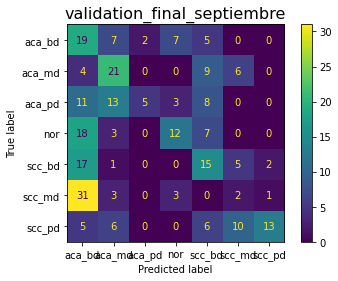

Precision: 0.4233690722665878
Recall: 0.3107142857142857
Accuracy: 0.3107142857142857


In [40]:
# Load the test images from the folder 'test_images'
predicted_labels= []
true_labels = []


#This is only for testing the code. Images are the same!

directory = "validation_final_septiembre"


label_mapping = {
    'aca_bd': 0,
    'aca_md': 1,
    'aca_pd': 2,
    'nor' : 3,
    'scc_bd' : 4,
    'scc_md' : 5, 
    'scc_pd' : 6
}

for filename in os.listdir(directory):

    # Load the image and add it to the list of test images
    f = os.path.join(directory, filename)

    #I use load image to load all the images and treat each piece as a separate image.
    imagenes = load_image(f, image_size)


    for imagen in imagenes:
        
        #imagen = np.array(imagen)/255

        x = np.expand_dims(imagen, axis=0)
        prediction = model.predict(x)
        predicted_class = np.argmax(prediction)

        if 'aca_bd' in filename:
            true_labels.append(0)
        elif 'aca_md' in filename:
            true_labels.append(1)
        elif 'aca_pd' in filename:
            true_labels.append(2)
        elif 'nor' in filename:
            true_labels.append(3)
        elif 'scc_bd' in filename:
            true_labels.append(4)    
        elif 'scc_md' in filename:
            true_labels.append(5)
        elif 'scc_pd' in filename:
            true_labels.append(6)       

        predicted_labels.append(predicted_class)
        
        # print(predicted_labels)
        # print(true_labels)

cm = confusion_matrix(true_labels, predicted_labels)
labels = [label for label, _ in sorted(label_mapping.items(), key=lambda x: x[1])]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

plt.title(directory,  fontdict={'fontsize': 16})  # Set the new title for the plot
plt.show()


# Calculate precision, recall, and accuracy
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)